In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import CoolProp.CoolProp as Cool
from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

from pymoo.util.misc import stack
from pymoo.model.problem import Problem
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.optimize import minimize

plt.rc('font',family = 'serif',size = 12)
plt.rc('text', usetex = True)

In [2]:
def fan(V,a,b,c):
    P = a*V**2+b*V + c
    return P

DELETE THIS CELL  ---- #Properties of the water

visc=Cool.PropsSI('V','T',273.15+10,'P',101325,'Water')
rho=Cool.PropsSI('D','T',273.15+28,'P',101325,'Water')
k_f=Cool.PropsSI('L','T',273.15+28,'P',101325,'Water')
Pr=Cool.PropsSI('PRANDTL','T',273.15+28,'P',101325,'Water')
cp_f=Cool.PropsSI('C','T',273.15+28,'P',101325,'Water')

In [3]:
#Properties of the water

rho_w = 997        #[kg/m3] Density (25ºC)
cp_w  = 4181       #[kJ/kg.K] Specific heat

mu_wc = Cool.PropsSI('V','T',273.15+10,'P',101325,'Water')
mu_wh = Cool.PropsSI('V','T',273.15+40,'P',101325,'Water')


Pr_wc = Cool.PropsSI('PRANDTL','T',273.15+10,'P',101325,'Water')
Pr_wh = Cool.PropsSI('PRANDTL','T',273.15+40,'P',101325,'Water')

k_wc=Cool.PropsSI('L','T',273.15+10,'P',101325,'Water')
k_wh=Cool.PropsSI('L','T',273.15+40,'P',101325,'Water')

#Properties of air at 25ºC

rho_a = 1.168      #[kg/m3] Density
mu_a  = 0.00001849 #[kg/(m.s)] Viscosity
cp_a  = 1004      #[kJ/kg.K] Specific heat
Pr_a  = 0.7281     #[-] Prandtl number

#Properties of the metals

k_w = 273 
rho_al = 2700
rho_cu = 9000
rho_wa = 1000

In [4]:
#Fan Calculations

dP_fan = np.array([0,30,60,80])
V_fan = np.array([3200,2775,2270,1760])/3600
eta_fan = (dP_fan*V_fan)/np.array([134,142,151,158])
Coef_fan = curve_fit(fan,V_fan,dP_fan,maxfev=10000)
Coef_eta = curve_fit(fan,V_fan,eta_fan,maxfev=10000)

In [5]:
def HEx(Data_Master):
    
    Xl,Xt,N_r,N_l,L1,Di,pf,xf,sigmaf,sigmah,pd,m_f1,Nucleos = Data_Master
    
    
    xf = 7*10**-3
    De = Di + 0.001
    m_f = m_f1/Nucleos
    Beta = 1/pf
    Nfin = Beta*L1   
    
    dc = De + 2*sigmaf
    theta = np.arctan(pd/xf)

    L3 = (N_l*Xt)/2*Nucleos
    L2 = N_r*Xl
    N_t = N_r*N_l/2*Nucleos 

    a = ((Xt - De) - (Xt - De)*sigmaf/np.cos(theta)*Beta)/2
    b = ((Xt/2)**2+Xl**2)**0.5 - De - (Xt-De)*sigmaf/np.cos(theta)*Beta
    if a<b:
        c = 2*a
    else:
        c = 2*b
    A_min_o = ((L3/Xt-1)*c + (Xt-De)-(Xt-De)*sigmaf/np.cos(theta)*Beta)*L1 #Minimum free flow area
    
    
    A_fr = L1*L3 #Frontal area
    
    sigma = A_min_o/A_fr
    
    
    A_p = np.pi*De*(L1-sigmaf*Beta*L1/np.cos(theta))*N_t+2*(L2*L3 - np.pi*De**2*N_t/4) #Primary surface area  - exposed tubes and header plates
    A_f = 2*(L2*L3/np.cos(theta)-(np.pi*De**2/4)*N_t)*Beta*L1 + 2*L3*sigmaf*Beta*L1/np.cos(theta)
    A_s = A_p + A_f       #Total heat transfer area
    A_t = np.pi*De*L1*N_t #External tube area
    
    sigma_o = (L3*L1 - L3*sigmaf*Beta*L1)/(L3*L1) #area concentration/expansion ratio
    D_h = 4*A_min_o*L2/A_s #Hydraulic diameter
    
    #Correlation parameters
    
    c1 = -0.1707 - 1.374*((Xl/sigmaf)**(-0.493))*((pf/dc)**(-0.886))*((N_r)**(-0.143))*((pd/xf)**(-0.0296))
    c2 = 0.1714 - 0.07372*((pf/Xl)**0.25)*(np.log(A_s/A_t))*((pd/xf)**(-0.2))
    c3 = 0.426*((pf/Xt)**0.3)*(np.log(A_s/A_t))    

        
    #Pressure drop correlation
    def PressureDrop(vazao):
        u_air = vazao/(L1*L3)
        u_max = u_air/sigma
        Re = u_max*rho_a*dc/(mu_a)
        c4 = -10.2192/np.log(Re)
        f_o  = 0.05273*(Re**c2)*((pd/xf)**c3)*((pf/Xt)**c4)*((np.log(A_s/A_t))**(-2.726))*(D_h/dc)**0.1325*((N_r)**0.02305)   
        G_o = rho_a*u_max

        dP_o = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
        dP_fan = fan(vazao,Coef_fan[0][0],Coef_fan[0][1],Coef_fan[0][2])
        return(dP_o-dP_fan)
    
    vazao = fsolve(PressureDrop,3000)
    u_air = vazao/(L1*L3)
    u_max = u_air/sigma
    Re = u_max*rho_a*dc/(mu_a)
    Re_o = Re
    c4 = -10.2192/np.log(Re)
    f_o  = 0.05273*(Re**c2)*((pd/xf)**c3)*((pf/Xt)**c4)*((np.log(A_s/A_t))**(-2.726))*(D_h/dc)**0.1325*((N_r)**0.02305)   
    G_o = rho_a*u_max

    dP_o = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
    dP_fan = fan(vazao,Coef_fan[0][0],Coef_fan[0][1],Coef_fan[0][2])
    
    j_o = 1.7910*((Re)**c1)*((Xl/sigmaf)**(-0.456))*((N_r)**(-0.27))*((pf/dc)**(-1.343))*((pd/xf)**0.317)
    h_o = j_o*rho_a*u_max*cp_a*Pr_a**(-0.66666)

    #Fin efficiency

    m = ((2*h_o)/(k_w*sigmaf))**0.5

    Pm = Xl/2
    Pl = (((Xt/2)**2+Xl**2)**0.5)/2
    R_eq = 1.27*Pm*(Pl/Pm-0.3)**0.5
    phi = (R_eq/(Di/2)-1)*(1+0.35*np.log(R_eq/(Di/2)))
    eta = np.tanh(m*(Di/2)*phi)/(m*(Di/2)*phi)
    eta_o = 1 - (A_f/A_s)*(1-eta)

    Rt_o = 1/(eta_o*h_o*A_s/Nucleos)
    
    ## Internal Flow
    
    Lh=(L1+2*sigmah)*N_t/Nucleos
    A_i = np.pi*Di*L1*N_t/Nucleos
    A_min_i = np.pi*(Di**2)/4
    G_i = m_f/A_min_i
    
    Re_ic = G_i*Di/mu_wc 
    Re_ih = G_i*Di/mu_wh
    
    A_c = (2.457*np.log(1/((7/Re_ic)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_c = (37530/Re_ic)**16
    
    A_h = (2.457*np.log(1/((7/Re_ih)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_h = (37530/Re_ih)**16
    
    f_c = (8*((8/Re_ic)**12 + (A_c + B_c)**(-3/2))**(1/12))/4
    f_h = (8*((8/Re_ih)**12 + (A_h + B_h)**(-3/2))**(1/12))/4
    
    
    
    if Re_ih < 2300:
        Nu_ih = 3.66
    else:
        Nu_ih = ((f_h/2)*(Re_ih-1000)*Pr_wh)/(1+12.7*((f_h/2)**0.5)*(Pr_wh**(2/3)-1))
                                              
    if Re_ic < 2300:
        Nu_ic = 3.66
    else:
        Nu_ic = ((f_c/2)*(Re_ic-1000)*Pr_wc)/(1+12.7*((f_c/2)**0.5)*(Pr_wc**(2/3)-1))   
    
       
    
    h_i_c = Nu_ic*k_wc/Di
    h_i_h = Nu_ih*k_wh/Di
        
    Rt_i_c = 1/(h_i_c*A_i)
    Rt_i_h = 1/(h_i_h*A_i)
    
    K_bend = 50
    
    
    dP_i_c = f_c*G_i**2*4*(Lh/Di + (N_t/Nucleos)*K_bend)/(2*rho_w)
    dP_i_h = f_h*G_i**2*4*(Lh/Di + (N_t/Nucleos)*K_bend)/(2*rho_w)
    
    #http://hydroneng.com/pipelines/
    #http://www.thermopedia.com/content/577/
    #print(200*f_c,np.pi*Xt/2,Lh)
                                              
    W_p_c = dP_i_c*m_f/rho_w
    W_p_h = dP_i_h*m_f/rho_w
    
    R_tub = np.log(De/Di)/(2*np.pi*L1*N_t/Nucleos*k_w)
    
    
    UA_h = (Rt_o + R_tub + Rt_i_h)**-1
    UA_c = (Rt_o + R_tub + Rt_i_c)**-1
    
       
    eta_fan = fan(vazao,Coef_eta[0][0],Coef_eta[0][1],Coef_eta[0][2])
    W_o = vazao*dP_o/eta_fan
    
    NTU_c = UA_c/(vazao/Nucleos*rho_a*cp_a)
    NTU_h = UA_h/(vazao/Nucleos*rho_a*cp_a)
    
    C_r = (vazao/Nucleos*rho_a*cp_a)/(m_f*cp_w)
    
    if N_r == 1:
        Eff_h = (1-np.exp(-C_r*(1-np.exp(-NTU_h))))/C_r
        Eff_c = (1-np.exp(-C_r*(1-np.exp(-NTU_c))))/C_r
    elif N_r == 2:
        K = (1-np.exp(-NTU_h/2))
        Eff_h = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
        K = (1-np.exp(-NTU_c/2))
        Eff_c = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
    elif N_r == 3:
        K = (1-np.exp(-NTU_h/3))
        Eff_h = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
        K = (1-np.exp(-NTU_c/3))
        Eff_c = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
    elif N_r ==4:
        K = (1-np.exp(-NTU_h/4))
        Eff_h = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
        K = (1-np.exp(-NTU_c/4))
        Eff_c = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
    else:
        Eff_h = 1 - np.exp(NTU_h**0.22*(np.exp(-C_r*NTU_h**0.78)-1)/C_r)
        Eff_c = 1 - np.exp(NTU_c**0.22*(np.exp(-C_r*NTU_c**0.78)-1)/C_r) 
    
    ECr_c = Eff_c*C_r
    ECr_h = Eff_h*C_r
    
    
    m_fin = Beta*L1*(L2*L3/np.cos(theta)-np.pi*De**2*N_t)*sigmaf*rho_al
    m_hea = 2*(L2*L3-np.pi*De**2*N_t)*sigmah*rho_al
    m_tub = (np.pi*(De**2-Di**2)/4*(L1 + np.pi/2*(Xt**2+Xl**2)**0.5)*N_t)*rho_cu
    m_w   = (np.pi*Di**2/4*(L1+np.pi/2*(Xt**2+Xl**2)**0.5)*N_t)*rho_w

    return(ECr_c,ECr_h,Eff_c,Eff_h,C_r,NTU_c,NTU_h,W_p_c*Nucleos,W_p_h*Nucleos,W_o,dP_o,vazao*3600,Re_o,f_o,j_o,eta_o,eta_fan,m_fin,m_hea,m_tub,m_w,dP_i_c,dP_i_h) 

In [31]:
def HEx_MOO(Data_Master):
    
    Xl,Xt,N_r,N_l,L1,Di,pf,Nucleos = Data_Master
    
    p_d = 0.0018
    sigmah = 0.00030 
    sigmaf = 0.15*10**-3
    xf = 7*10**-3
    De = (Di + 0.001)
    m_f = m_f1/Nucleos
    Beta = 1/pf
    Nfin = Beta*L1   
    
    dc = (De + 2*sigmaf)
    theta = np.arctan(p_d/xf)

    L3 = ((N_l*Xt)/2*Nucleos)
    L2 = (N_r*Xl)
    N_t = (N_r*N_l/2*Nucleos)
    a = (((Xt - De) - (Xt - De)*sigmaf/np.cos(theta)*Beta)/2)
    b = (((Xt/2)**2+Xl**2)**0.5 - De - (Xt-De)*sigmaf/np.cos(theta)*Beta)
    

    if a<b:
        c = 2*a
    else:
        c = 2*b
    A_min_o = ((L3/Xt-1)*c + (Xt-De)-(Xt-De)*sigmaf/np.cos(theta)*Beta)*L1 #Minimum free flow area
    
    A_fr = L1*L3 #Frontal area
    
    sigma = A_min_o/A_fr
    
    A_p = np.pi*De*(L1-sigmaf*Beta*L1/np.cos(theta))*N_t+2*(L2*L3 - np.pi*De**2*N_t/4) #Primary surface area  - exposed tubes and header plates
    A_f = 2*(L2*L3/np.cos(theta)-(np.pi*De**2/4)*N_t)*Beta*L1 + 2*L3*sigmaf*Beta*L1/np.cos(theta)
    A_s = A_p + A_f       #Total heat transfer area
    A_t = np.pi*De*L1*N_t #External tube area
    
    sigma_o = (L3*L1 - L3*sigmaf*Beta*L1)/(L3*L1) #area concentration/expansion ratio
    D_h = 4*A_min_o*L2/A_s #Hydraulic diameter
    
    #Correlation parameters
    
    
    c1 = -0.1707 - 1.374*((Xl/sigmaf)**(-0.493))*((pf/dc)**(-0.886))*((N_r)**(-0.143))*((p_d/xf)**(-0.0296))
    c2 = 0.1714 - 0.07372*((pf/Xl)**0.25)*(np.log((A_s/A_t)))*((p_d/xf)**(-0.2))
    c3 = 0.426*((pf/Xt)**0.3)*(np.log((A_s/A_t)))    

    #Pressure drop correlation
    def PressureDrop(vazao):
        u_air = vazao/(L1*L3)
        u_max = u_air/sigma
        Re = (u_max*rho_a*dc/(mu_a)).astype('float64')
        c4 = -10.2192/np.log(Re)
        f_o  = 0.05273*(Re**c2)*((p_d/xf)**c3)*((pf/Xt)**c4)*((np.log((A_s/A_t)))**(-2.726))*(D_h/dc)**0.1325*((N_r)**0.02305)   
        G_o = rho_a*u_max

        dP_o = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
        dP_fan = fan(np.array(list(vazao)),Coef_fan[0][0],Coef_fan[0][1],Coef_fan[0][2])
        
        return(dP_o-dP_fan)
    
    vazao = fsolve(PressureDrop,3000/3600)
    u_air = vazao/(L1*L3)
    u_max = u_air/sigma
    Re = u_max*rho_a*dc/(mu_a)
    Re_o = Re
    c4 = -10.2192/np.log(Re)
    f_o  = 0.05273*(Re**c2)*((p_d/xf)**c3)*((pf/Xt)**c4)*((np.log((A_s/A_t)))**(-2.726))*(D_h/dc)**0.1325*((N_r)**0.02305)   
    G_o = rho_a*u_max

    dP_o = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
    dP_fan = fan(vazao,Coef_fan[0][0],Coef_fan[0][1],Coef_fan[0][2])
    
    j_o = 1.7910*((Re)**c1)*((Xl/sigmaf)**(-0.456))*((N_r)**(-0.27))*((pf/dc)**(-1.343))*((p_d/xf)**0.317)
    h_o = j_o*rho_a*u_max*cp_a*Pr_a**(-0.66666)

    #Fin efficiency

    m = ((2*h_o)/(k_w*sigmaf))**0.5

    Pm = Xl/2
    Pl = (((Xt/2)**2+Xl**2)**0.5)/2
    R_eq = 1.27*Pm*(Pl/Pm-0.3)**0.5
    phi = (R_eq/(Di/2)-1)*(1+0.35*np.log(R_eq/(Di/2)))
    eta = np.tanh(m*(Di/2)*phi)/(m*(Di/2)*phi)
    eta_o = 1 - (A_f/A_s)*(1-eta)

    Rt_o = 1/(eta_o*h_o*A_s/Nucleos)
    
    ## Internal Flow
    
    Lh=(L1+2*sigmah)*N_t/Nucleos
    A_i = np.pi*Di*L1*N_t/Nucleos
    A_min_i = np.pi*(Di**2)/4
    G_i = m_f/A_min_i
    
    Re_ic = G_i*Di/mu_wc 
    Re_ih = G_i*Di/mu_wh
    
    A_c = (2.457*np.log(1/((7/Re_ic)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_c = (37530/Re_ic)**16
    
    A_h = (2.457*np.log(1/((7/Re_ih)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_h = (37530/Re_ih)**16
    
    f_c = (8*((8/Re_ic)**12 + (A_c + B_c)**(-3/2))**(1/12))/4
    f_h = (8*((8/Re_ih)**12 + (A_h + B_h)**(-3/2))**(1/12))/4
    
    
    
    

    if Re_ih < 2300:
        Nu_ih = 3.66
    else:
        Nu_ih = ((f_h/2)*(Re_ih-1000)*Pr_wh)/(1+12.7*((f_h/2)**0.5)*(Pr_wh**(2/3)-1))

    if Re_ic < 2300:
        Nu_ic = 3.66
    else:
        Nu_ic = ((f_c/2)*(Re_ic-1000)*Pr_wc)/(1+12.7*((f_c/2)**0.5)*(Pr_wc**(2/3)-1))   
    
       
    
    h_i_c = Nu_ic*k_wc/Di
    h_i_h = Nu_ih*k_wh/Di
        
    Rt_i_c = 1/(h_i_c*A_i)
    Rt_i_h = 1/(h_i_h*A_i)
    
    K_bend = 50
    
    
    dP_i_c = f_c*G_i**2*4*(Lh/Di + (N_t/Nucleos)*K_bend)/(2*rho_w)
    dP_i_h = f_h*G_i**2*4*(Lh/Di + (N_t/Nucleos)*K_bend)/(2*rho_w)
    
    #http://hydroneng.com/pipelines/
    #http://www.thermopedia.com/content/577/
    #print(200*f_c,np.pi*Xt/2,Lh)
                                              
    W_p_c = dP_i_c*m_f/rho_w
    W_p_h = dP_i_h*m_f/rho_w
    
    R_tub = np.log(De/Di)/(2*np.pi*L1*N_t/Nucleos*k_w)
    
    
    UA_h = (Rt_o + R_tub + Rt_i_h)**-1
    UA_c = (Rt_o + R_tub + Rt_i_c)**-1
    
       
    eta_fan = fan(vazao,Coef_eta[0][0],Coef_eta[0][1],Coef_eta[0][2])
    W_o = vazao*dP_o/eta_fan
    
    NTU_c = UA_c/(vazao/Nucleos*rho_a*cp_a)
    NTU_h = UA_h/(vazao/Nucleos*rho_a*cp_a)
    
    C_r = (vazao/Nucleos*rho_a*cp_a)/(m_f*cp_w)
   

    if N_r == 1:
        Eff_h = (1-np.exp(-C_r*(1-np.exp(-NTU_h))))/C_r
        Eff_c = (1-np.exp(-C_r*(1-np.exp(-NTU_c))))/C_r
    elif N_r == 2:
        K = (1-np.exp(-NTU_h/2))
        Eff_h = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
        K = (1-np.exp(-NTU_c/2))
        Eff_c = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
    elif N_r == 3:
        K = (1-np.exp(-NTU_h/3))
        Eff_h = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
        K = (1-np.exp(-NTU_c/3))
        Eff_c = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
    elif N_r ==4:
        K = (1-np.exp(-NTU_h/4))
        Eff_h = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
        K = (1-np.exp(-NTU_c/4))
        Eff_c = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
    else:
        Eff_h = 1 - np.exp(NTU_h**0.22*(np.exp(-C_r*NTU_h**0.78)-1)/C_r)
        Eff_c = 1 - np.exp(NTU_c**0.22*(np.exp(-C_r*NTU_c**0.78)-1)/C_r) 

    ECr_c = Eff_c*C_r
    ECr_h = Eff_h*C_r
    
    
    m_fin = Beta*L1*(L2*L3/np.cos(theta)-np.pi*De**2*N_t)*sigmaf*rho_al
    m_hea = 2*(L2*L3-np.pi*De**2*N_t)*sigmah*rho_al
    m_tub = (np.pi*(De**2-Di**2)/4*(L1 + np.pi/2*(Xt**2+Xl**2)**0.5)*N_t)*rho_cu
    m_w   = (np.pi*Di**2/4*(L1+np.pi/2*(Xt**2+Xl**2)**0.5)*N_t)*rho_w
    
    return(ECr_c, W_p_c*Nucleos + W_o, dP_o,vazao*3600) 

In [23]:
class MyProblem(Problem):

    def __init__(self, **kwargs):
        super().__init__(n_var=8,
                         n_obj=2,
                         n_constr=4,
                         xl=np.array([27.5*10**-3, 31.75*10**-3, 1, 1, 0.35, 0 , 3*10**-3, 2]),
                         xu=np.array([33*10**-3  , 38.1*10**-3 , 4, 4, 0.55, 1 , 4.5*10**-3, 8]),
                         elementwise_evaluation=True, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        #FE,f,L,H,W,B_ap,Tc,Th,Tce,The,L_xt,d_par,h_f,phi_mag
        #Xl,Xt,N_r,N_l,L1,Di,pf,Nucleos
        Data_MOO = np.array([x[0],x[1],2*x[2],2*x[3],x[4],0.0117 + 0.0031*x[5],x[6],x[7]],dtype='float64')
        A,B,C,D = HEx_MOO(Data_MOO)
        
        
        f1 = -A
        f2 = B
        
        g1 = C - 80
        g2 = -B
        g4 = 0.3 - D
        g3 = D - 0.55

        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1,g2,g3,g4])

from multiprocessing.pool import ThreadPool

# the number of threads to be used
n_threads = 8

# initialize the pool
pool = ThreadPool(n_threads)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(parallelization = ('starmap', pool.starmap))

In [15]:
termination = MultiObjectiveSpaceToleranceTermination(tol=0.001,
                                                      n_last=200,
                                                      nth_gen=50,
                                                      n_max_gen=None,
                                                      n_max_evals=None)

In [16]:
mask = ["real","real","int","int","real","int","real","int"]

In [17]:
sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random"),
    "int": get_sampling("int_random"),
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random"),
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random")
    
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx", prob=0.9, eta=15.0),
    "real": get_crossover("real_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0),
    "real": get_crossover("real_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0),
    "real": get_crossover("real_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0)

})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm", eta=20.0),
    "real": get_mutation("real_pm", eta=20.0),
    "int": get_mutation("int_pm", eta=20.0),
    "int": get_mutation("int_pm", eta=20.0),
    "real": get_mutation("real_pm", eta=20.0),
    "int": get_mutation("int_pm", eta=20.0),
    "real": get_mutation("real_pm", eta=20.0),
    "int": get_mutation("int_pm", eta=20.0)    
})

In [19]:
algorithm = NSGA2(
    pop_size=1000,
    n_offsprings=300,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True
)

In [20]:
m_f1 = 1

In [21]:
from multiprocessing.pool import ThreadPool

# the number of threads to be used
n_threads = 8

# initialize the pool
pool = ThreadPool(n_threads)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(parallelization = ('starmap', pool.starmap))

In [ ]:
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=True)

print('Threads:', res.exec_time)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  | delta_ideal  | delta_nadir  |   delta_f   
    1 |    1000 |  1.67977E+02 |  2.21748E+03 |       1 |            - |            - |            -
    2 |    1300 |  1.67357E+02 |  1.46852E+03 |       1 |  0.076614580 |  0.076614580 |  7.66146E+28
    3 |    1600 |  1.67357E+02 |  1.16942E+03 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    4 |    1900 |  1.67143E+02 |  9.42010E+02 |       1 |  1.61270E+01 |  1.61270E+01 |  1.61270E+31
    5 |    2200 |  1.67143E+02 |  7.59547E+02 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    6 |    2500 |  1.59381E+02 |  5.99330E+02 |       1 |  0.305283711 |  0.305283711 |  3.05285E+29
    7 |    2800 |  1.46300E+02 |  4.59820E+02 |       1 |  1.401642397 |  1.401642397 |  1.40164E+30
    8 |    3100 |  1.43148E+02 |  3.60751E+02 |       1 |  0.516107758 |  0.516107758 |  5.16108E+29
    9 |    3400 |  1.32839E+02 |  2.99741E+02 |       1 |  0.338559822 |  0.338559822 |  3.

In [519]:
res.X.T[7]

array([7, 4, 3], dtype=object)

In [663]:
res.X.T[1]*res.X.T[3]*res.X.T[7]/2

array([0.2556247980613092, 0.2540743934141114, 0.260234903648845,
       0.25798878222514077, 0.2611132724666473, 0.2550940141776799,
       0.2738280636525334, 0.25802131065615097, 0.26556390066992624,
       0.2706869532382336, 0.256912499438036, 0.25725194105800103,
       0.2693391195331334, 0.2571762154769184, 0.26969765044713867,
       0.2689391460491072, 0.26602282912415864, 0.27312345479278366,
       0.26219996881237945, 0.2717690260396668, 0.2738280636525334,
       0.26896917051312774, 0.2566051725183725, 0.2698998036819145,
       0.2669422265606903, 0.27355602650673094, 0.26678252913153694,
       0.25809625466212605, 0.2634097120296112, 0.1511895595681133,
       0.2694727596918875, 0.15064942480258386, 0.254905832638296,
       0.2545157025693353, 0.15116853876004832, 0.15086991995989504,
       0.22448525930785285, 0.26678252913153694, 0.2747111449179528,
       0.2567259062641621, 0.25550900519460484, 0.27446221972388357,
       0.2540035466721204, 0.27446221972388357

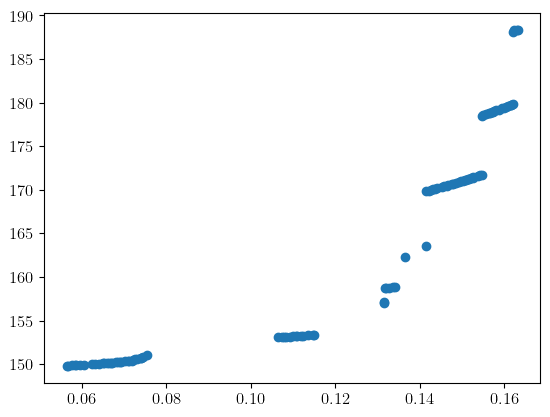

In [727]:
plt.plot(-res.F.T[0],res.F.T[1],'o')
#plt.ylim([150,180])-

In [536]:
p_d = 0.0018
sigmah = 0.00030 
sigmaf = 0.15*10**-3
xf = 7*10**-3

In [552]:
Nucleos = np.array([3,4,5,6,7,8])
Di = np.array([0.0117,0.0148])
m_f = np.arange(3600/3600,5405/3600,5000/3600)
Xt = np.arange(31.75*10**-3,1.01*38.1*10**-3,(38.1*10**-3-31.75*10**-3)/2)
Xl = np.arange(27.5*10**-3,1.01*33*10**-3,(33*10**-3-27.5*10**-3)/2)
pf = np.array([3,4])*10**-3
N_r = np.arange(2,8.1,2)
N_l = np.array([6,8])
L1  = np.arange(0.35,0.56,0.1) #np.arange(0.4,0.73,0.05)
xf = 7*10**-3

In [709]:
A = np.meshgrid(Xl,Xt,N_r,N_l,L1,Di,pf,xf,sigmaf,sigmah,p_d,m_f,Nucleos)
B = (np.array(A))
Data = B.T.reshape(-1,len(B))

In [700]:
Data = np.array([(res.X.T[0]).tolist(),
        (res.X.T[1]).tolist(),
        (2*res.X.T[2]).tolist(),
        (2*res.X.T[3]).tolist(),
        (res.X.T[4]).tolist(),
        (0.0117 + 0.0031*res.X.T[5]).tolist(),
        (res.X.T[6]).tolist(),
        xf*np.ones(len(res.X.T[0])),
        sigmaf*np.ones(len(res.X.T[0])),
        sigmah*np.ones(len(res.X.T[0])),
        p_d*np.ones(len(res.X.T[0])),
        m_f*np.ones(len(res.X.T[0])),
        (res.X.T[7]).tolist()]).T

In [710]:
#%%timeit

Res = np.zeros([len(Data),23])
Data_Final = np.zeros([len(Data),len(Data.T) + len(Res.T)])
for i in range (len(Data)):
    if  i % 1 == 0:
        print(i/(len(Data))*100)
    if Data[i][1]*Data[i][3]*Data[i][12]/2>0.3 and Data[i][1]*Data[i][3]*Data[i][12]/2<0.55:
        Res[i] = (HEx(Data[i]))
        if Res[i][10] < 80 and Res[i][11] < 2548:
            #print(i)
            Data_Final[i] = np.concatenate([Data[i],Res[i]])     

0.0
0.019290123456790122
0.038580246913580245
0.057870370370370364
0.07716049382716049
0.09645061728395062
0.11574074074074073
0.13503086419753085
0.15432098765432098
0.1736111111111111
0.19290123456790123
0.21219135802469136
0.23148148148148145
0.2507716049382716
0.2700617283950617
0.28935185185185186
0.30864197530864196
0.32793209876543206
0.3472222222222222
0.3665123456790123
0.38580246913580246
0.40509259259259256
0.4243827160493827
0.4436728395061728
0.4629629629629629
0.48225308641975306
0.5015432098765432
0.5208333333333333
0.5401234567901234
0.5594135802469136
0.5787037037037037
0.5979938271604938
0.6172839506172839
0.6365740740740741
0.6558641975308641
0.6751543209876543
0.6944444444444444
0.7137345679012346
0.7330246913580246
0.7523148148148148
0.7716049382716049
0.7908950617283951
0.8101851851851851
0.8294753086419754
0.8487654320987654
0.8680555555555556
0.8873456790123456
0.9066358024691359
0.9259259259259258
0.9452160493827161
0.9645061728395061
0.9837962962962963
1.00308

8.719135802469136
8.738425925925926
8.757716049382717
8.777006172839506
8.796296296296296
8.815586419753087
8.834876543209877
8.854166666666668
8.873456790123457
8.892746913580247
8.912037037037036
8.931327160493826
8.950617283950617
8.969907407407407
8.989197530864198
9.008487654320987
9.027777777777777
9.047067901234568
9.066358024691358
9.085648148148149
9.104938271604938
9.124228395061728
9.143518518518519
9.162808641975309
9.1820987654321
9.20138888888889
9.220679012345679
9.239969135802468
9.25925925925926
9.278549382716049
9.297839506172838
9.31712962962963
9.33641975308642
9.35570987654321
9.375
9.39429012345679
9.41358024691358
9.43287037037037
9.452160493827162
9.471450617283951
9.49074074074074
9.510030864197532
9.529320987654321
9.54861111111111
9.5679012345679
9.587191358024691
9.606481481481481
9.625771604938272
9.645061728395062
9.664351851851851
9.683641975308642
9.702932098765432
9.722222222222223
9.741512345679013
9.760802469135802
9.780092592592593
9.799382716049383


17.611882716049383
17.631172839506174
17.650462962962962
17.669753086419753
17.689043209876544
17.708333333333336
17.727623456790123
17.746913580246915
17.766203703703702
17.785493827160494
17.804783950617285
17.824074074074073
17.843364197530864
17.86265432098765
17.881944444444446
17.901234567901234
17.920524691358025
17.939814814814813
17.959104938271604
17.978395061728396
17.997685185185187
18.016975308641975
18.036265432098766
18.055555555555554
18.07484567901235
18.094135802469136
18.113425925925927
18.132716049382715
18.152006172839506
18.171296296296298
18.190586419753085
18.209876543209877
18.229166666666664
18.248456790123456
18.267746913580247
18.287037037037038
18.306327160493826
18.325617283950617
18.34490740740741
18.3641975308642
18.383487654320987
18.40277777777778
18.422067901234566
18.441358024691358
18.46064814814815
18.479938271604937
18.499228395061728
18.51851851851852
18.53780864197531
18.557098765432098
18.57638888888889
18.595679012345677
18.61496913580247
18.6

26.42746913580247
26.446759259259263
26.46604938271605
26.48533950617284
26.504629629629626
26.52391975308642
26.543209876543212
26.5625
26.581790123456788
26.60108024691358
26.620370370370374
26.63966049382716
26.65895061728395
26.678240740740737
26.69753086419753
26.716820987654323
26.73611111111111
26.7554012345679
26.774691358024693
26.79398148148148
26.813271604938272
26.83256172839506
26.851851851851855
26.871141975308642
26.890432098765434
26.90972222222222
26.92901234567901
26.948302469135804
26.96759259259259
26.986882716049383
27.00617283950617
27.025462962962965
27.044753086419753
27.064043209876544
27.083333333333332
27.102623456790127
27.121913580246915
27.141203703703702
27.160493827160494
27.179783950617285
27.199074074074076
27.218364197530864
27.23765432098765
27.256944444444443
27.276234567901238
27.295524691358025
27.314814814814813
27.334104938271604
27.353395061728396
27.372685185185187
27.391975308641975
27.411265432098762
27.430555555555557
27.44984567901235
27.4

35.223765432098766
35.24305555555556
35.26234567901235
35.28163580246913
35.300925925925924
35.320216049382715
35.339506172839506
35.3587962962963
35.37808641975309
35.39737654320987
35.41666666666667
35.435956790123456
35.45524691358025
35.47453703703704
35.49382716049383
35.51311728395062
35.532407407407405
35.551697530864196
35.57098765432099
35.59027777777778
35.60956790123457
35.628858024691354
35.648148148148145
35.66743827160494
35.68672839506173
35.70601851851852
35.7253086419753
35.7445987654321
35.76388888888889
35.78317901234568
35.80246913580247
35.82175925925926
35.84104938271605
35.86033950617284
35.879629629629626
35.898919753086425
35.91820987654321
35.9375
35.95679012345679
35.976080246913575
35.995370370370374
36.01466049382716
36.03395061728395
36.05324074074074
36.07253086419753
36.09182098765432
36.11111111111111
36.1304012345679
36.1496913580247
36.16898148148148
36.18827160493827
36.20756172839506
36.226851851851855
36.246141975308646
36.26543209876543
36.2847222

45.910493827160494
45.929783950617285
45.949074074074076
45.96836419753087
45.98765432098765
46.00694444444444
46.026234567901234
46.045524691358025
46.06481481481482
46.0841049382716
46.1033950617284
46.12268518518518
46.141975308641975
46.161265432098766
46.18055555555556
46.19984567901235
46.21913580246913
46.238425925925924
46.257716049382715
46.277006172839506
46.2962962962963
46.31558641975309
46.33487654320987
46.35416666666667
46.373456790123456
46.39274691358025
46.41203703703704
46.43132716049383
46.45061728395062
46.469907407407405
46.489197530864196
46.50848765432099
46.52777777777778
46.54706790123457
46.566358024691354
46.585648148148145
46.60493827160494
46.62422839506173
46.64351851851852
46.6628086419753
46.6820987654321
46.70138888888889
46.72067901234568
46.73996913580247
46.75925925925926
46.77854938271605
46.79783950617284
46.817129629629626
46.836419753086425
46.85570987654321
46.875
46.89429012345679
46.913580246913575
46.932870370370374
46.95216049382716
46.9714

69.52160493827161
69.54089506172839
69.56018518518519
69.57947530864197
69.59876543209876
69.61805555555556
69.63734567901234
69.65663580246914
69.67592592592592
69.69521604938271
69.7145061728395
69.73379629629629
69.75308641975309
69.77237654320987
69.79166666666666
69.81095679012346
69.83024691358025
69.84953703703704
69.86882716049382
69.8881172839506
69.9074074074074
69.9266975308642
69.94598765432099
69.96527777777779
69.98456790123457
70.00385802469135
70.02314814814815
70.04243827160494
70.06172839506173
70.08101851851852
70.1003086419753
70.1195987654321
70.13888888888889
70.15817901234568
70.17746913580247
70.19675925925925
70.21604938271605
70.23533950617285
70.25462962962963
70.27391975308642
70.2932098765432
70.3125
70.3317901234568
70.35108024691358
70.37037037037037
70.38966049382715
70.40895061728395
70.42824074074075
70.44753086419753
70.46682098765432
70.48611111111111
70.5054012345679
70.5246913580247
70.54398148148148
70.56327160493827
70.58256172839506
70.601851851

84.64506172839506
84.66435185185185
84.68364197530865
84.70293209876543
84.72222222222221
84.74151234567901
84.7608024691358
84.7800925925926
84.7993827160494
84.81867283950618
84.83796296296296
84.85725308641975
84.87654320987654
84.89583333333334
84.91512345679013
84.93441358024691
84.95370370370371
84.9729938271605
84.99228395061729
85.01157407407408
85.03086419753086
85.05015432098766
85.06944444444444
85.08873456790124
85.10802469135803
85.12731481481481
85.14660493827161
85.16589506172839
85.18518518518519
85.20447530864197
85.22376543209876
85.24305555555556
85.26234567901234
85.28163580246914
85.30092592592592
85.32021604938271
85.3395061728395
85.35879629629629
85.37808641975309
85.39737654320987
85.41666666666666
85.43595679012346
85.45524691358025
85.47453703703704
85.49382716049382
85.5131172839506
85.5324074074074
85.5516975308642
85.57098765432099
85.59027777777779
85.60956790123457
85.62885802469135
85.64814814814815
85.66743827160494
85.68672839506173
85.70601851851852


98.4375
98.4567901234568
98.47608024691358
98.49537037037037
98.51466049382715
98.53395061728395
98.55324074074075
98.57253086419753
98.59182098765432
98.61111111111111
98.6304012345679
98.6496913580247
98.66898148148148
98.68827160493827
98.70756172839506
98.72685185185185
98.74614197530865
98.76543209876543
98.78472222222221
98.80401234567901
98.8233024691358
98.8425925925926
98.8618827160494
98.88117283950618
98.90046296296296
98.91975308641975
98.93904320987654
98.95833333333334
98.97762345679013
98.99691358024691
99.01620370370371
99.0354938271605
99.05478395061729
99.07407407407408
99.09336419753086
99.11265432098766
99.13194444444444
99.15123456790124
99.17052469135803
99.18981481481481
99.20910493827161
99.22839506172839
99.24768518518519
99.26697530864197
99.28626543209876
99.30555555555556
99.32484567901234
99.34413580246914
99.36342592592592
99.38271604938271
99.4020061728395
99.42129629629629
99.44058641975309
99.45987654320987
99.47916666666666
99.49845679012346
99.5177469

In [711]:
df = pd.DataFrame(Data_Final, columns = ['Xl','Xt','N_r','N_l','L1','Di','pf','xf','sigmaf','sigmah','p_d','m_f','Nucleos','ECr_c','ECr_h','Eff_c','Eff_h','C_r','NTU_c','NTU_h','W_p_c','W_p_h','W_o','dP_o','vazao*3600','Re_o','f_o','j_o','eta_o','eta_fan','m_fin','m_hea','m_tub','m_w','dP_c','dP_h'])
df_mf = df.groupby('m_f')
df_mf.get_group(m_f[0])

,Xl,Xt,N_r,N_l,L1,Di,pf,xf,sigmaf,sigmah,...,f_o,j_o,eta_o,eta_fan,m_fin,m_hea,m_tub,m_w,dP_c,dP_h
1,0.02750,0.034925,2.0,6.0,0.35,0.0117,0.003,0.007,0.00015,0.0003,...,0.027089,0.005631,0.828037,0.263291,0.412471,0.013231,1.303357,0.810024,55985.190288,48187.129049
2,0.02750,0.038100,2.0,6.0,0.35,0.0117,0.003,0.007,0.00015,0.0003,...,0.026431,0.005750,0.820810,0.254510,0.489146,0.015777,1.315722,0.817709,55985.190288,48187.129049
4,0.03025,0.034925,2.0,6.0,0.35,0.0117,0.003,0.007,0.00015,0.0003,...,0.023312,0.006204,0.768825,0.263023,0.496814,0.016031,1.311900,0.815334,55985.190288,48187.129049
5,0.03025,0.038100,2.0,6.0,0.35,0.0117,0.003,0.007,0.00015,0.0003,...,0.022909,0.006344,0.762105,0.252355,0.581156,0.018832,1.323820,0.822742,55985.190288,48187.129049
7,0.03300,0.034925,2.0,6.0,0.35,0.0117,0.003,0.007,0.00015,0.0003,...,0.020447,0.006747,0.706920,0.262549,0.581156,0.018832,1.320900,0.820927,55985.190288,48187.129049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2544,0.03300,0.031750,6.0,6.0,0.55,0.0148,0.004,0.007,0.00015,0.0003,...,0.041270,0.010473,0.836906,0.255433,1.491375,0.038416,12.107086,9.600509,30832.500373,25984.656463
2545,0.03300,0.034925,6.0,6.0,0.55,0.0148,0.004,0.007,0.00015,0.0003,...,0.039338,0.010594,0.830554,0.260823,2.033577,0.053692,12.176065,9.655208,30832.500373,25984.656463
2548,0.02750,0.034925,8.0,6.0,0.55,0.0148,0.004,0.007,0.00015,0.0003,...,0.058649,0.010226,0.914401,0.255537,1.386053,0.034248,16.088090,12.757311,41110.000497,34646.208617
2551,0.03025,0.034925,8.0,6.0,0.55,0.0148,0.004,0.007,0.00015,0.0003,...,0.048263,0.010724,0.878073,0.259425,2.048745,0.052918,16.159514,12.813948,41110.000497,34646.208617


In [712]:
#df.to_excel("Data_HEx.xlsx")

In [713]:
#df =pd.read_excel("Dissertation.xlsx", columns = ['Xl','Xt','N_r','N_l','L1','Di','pf','xf','sigmaf','sigmah','p_d','m_f','Nucleos','ECr_c','ECr_h','Eff_c','Eff_h','C_r','NTU_c','NTU_h','W_p_c','W_p_h','W_o','dP_o','vazao*3600','Re_o','f_o','j_o','eta_o','eta_fan','m_fin','m_hea','m_tub','m_w','dP_c','dP_h'])

In [714]:
Xl_1 = [[] for i in range(len(m_f))]
Xt_1 = [[] for i in range(len(m_f))]
Nr_1 = [[] for i in range(len(m_f))]
Nl_1 = [[] for i in range(len(m_f))]
L1_1 = [[] for i in range(len(m_f))]
Di_1 = [[] for i in range(len(m_f))]
pf_1 = [[] for i in range(len(m_f))]
mf_1 = [[] for i in range(len(m_f))]
Nucleos_1 = [[] for i in range(len(m_f))]
Ecrc_1 = [[] for i in range(len(m_f))]
Ecrh_1 = [[] for i in range(len(m_f))]
Efc_1 = [[] for i in range(len(m_f))]
Efh_1 = [[] for i in range(len(m_f))]
C_1 = [[] for i in range(len(m_f))]
NTUc_1 = [[] for i in range(len(m_f))]
NTUh_1 = [[] for i in range(len(m_f))]
Wpc_1 = [[] for i in range(len(m_f))]
Wph_1 = [[] for i in range(len(m_f))]
Wo_1 = [[] for i in range(len(m_f))]
dPo_1 = [[] for i in range(len(m_f))]
cfm_1 = [[] for i in range(len(m_f))]
Reo_1 = [[] for i in range(len(m_f))]
fo_1 = [[] for i in range(len(m_f))]
jo_1 = [[] for i in range(len(m_f))]
etao_1 = [[] for i in range(len(m_f))]
etaf_1 = [[] for i in range(len(m_f))]
mfin_1 = [[] for i in range(len(m_f))]
mhea_1 = [[] for i in range(len(m_f))]
mtub_1 = [[] for i in range(len(m_f))]
mwa_1 = [[] for i in range(len(m_f))]
dPc_1 = [[] for i in range(len(m_f))]
dPh_1 = [[] for i in range(len(m_f))]


ECr = [[] for i in range(len(m_f))]
W_Tc = [[] for i in range(len(m_f))]
W_Th = [[] for i in range(len(m_f))]
W_o = [[] for i in range(len(m_f))]
m_tot = [[] for i in range(len(m_f))]
Count = [[] for i in range(len(m_f))]

for i in range(len(m_f)):    
    ECr[i].append(np.array(df_mf.get_group(m_f[i])['ECr_c']))
    W_Tc[i].append(np.array(df_mf.get_group(m_f[i])['W_o']+df_mf.get_group(m_f[i])['W_p_c']))
    W_Th[i].append(np.array(df_mf.get_group(m_f[i])['W_o']+df_mf.get_group(m_f[i])['W_p_h']))
    m_tot[i].append(np.array(df_mf.get_group(m_f[i])['m_fin']+df_mf.get_group(m_f[i])['m_tub']+df_mf.get_group(m_f[i])['m_hea']+df_mf.get_group(m_f[i])['m_w']))
    W_o[i].append(np.array(df_mf.get_group(m_f[i])['W_p_c']))
    m_tot[i].append(np.array(df_mf.get_group(m_f[i])['m_fin']+df_mf.get_group(m_f[i])['m_tub']+df_mf.get_group(m_f[i])['m_hea']+df_mf.get_group(m_f[i])['m_w']))
    
    Xl_1[i].append(np.array(df_mf.get_group(m_f[i])['Xl']))
    Xt_1[i].append(np.array(df_mf.get_group(m_f[i])['Xt']))
    Nr_1[i].append(np.array(df_mf.get_group(m_f[i])['N_r']))
    Nl_1[i].append(np.array(df_mf.get_group(m_f[i])['N_l']))
    L1_1[i].append(np.array(df_mf.get_group(m_f[i])['L1']))
    Di_1[i].append(np.array(df_mf.get_group(m_f[i])['Di']))
    pf_1[i].append(np.array(df_mf.get_group(m_f[i])['pf']))
    mf_1[i].append(np.array(df_mf.get_group(m_f[i])['m_f']))
    Nucleos_1[i].append(np.array(df_mf.get_group(m_f[i])['Nucleos']))
    Ecrc_1[i].append(np.array(df_mf.get_group(m_f[i])['ECr_c']))
    Ecrh_1[i].append(np.array(df_mf.get_group(m_f[i])['ECr_h']))
    Efc_1[i].append(np.array(df_mf.get_group(m_f[i])['Eff_c']))
    Efh_1[i].append(np.array(df_mf.get_group(m_f[i])['Eff_h']))
    C_1[i].append(np.array(df_mf.get_group(m_f[i])['C_r']))
    NTUc_1[i].append(np.array(df_mf.get_group(m_f[i])['NTU_c']))
    NTUh_1[i].append(np.array(df_mf.get_group(m_f[i])['NTU_h']))
    Wpc_1[i].append(np.array(df_mf.get_group(m_f[i])['W_p_c']))
    Wph_1[i].append(np.array(df_mf.get_group(m_f[i])['W_p_h']))
    Wo_1[i].append(np.array(df_mf.get_group(m_f[i])['W_o']))
    dPo_1[i].append(np.array(df_mf.get_group(m_f[i])['dP_o']))
    cfm_1[i].append(np.array(df_mf.get_group(m_f[i])['vazao*3600']))
    Reo_1[i].append(np.array(df_mf.get_group(m_f[i])['Re_o']))
    fo_1[i].append(np.array(df_mf.get_group(m_f[i])['f_o']))
    jo_1[i].append(np.array(df_mf.get_group(m_f[i])['j_o']))
    etao_1[i].append(np.array(df_mf.get_group(m_f[i])['eta_o']))
    etaf_1[i].append(np.array(df_mf.get_group(m_f[i])['eta_fan']))
    mfin_1[i].append(np.array(df_mf.get_group(m_f[i])['m_fin']))
    mhea_1[i].append(np.array(df_mf.get_group(m_f[i])['m_hea']))
    mtub_1[i].append(np.array(df_mf.get_group(m_f[i])['m_tub']))
    mwa_1[i].append(np.array(df_mf.get_group(m_f[i])['m_w']))
    dPc_1[i].append(np.array(df_mf.get_group(m_f[i])['dP_c']))
    dPh_1[i].append(np.array(df_mf.get_group(m_f[i])['dP_h']))
    

In [715]:
Cont = [[] for i in range(len(m_f))]
Ec_p_L = [[] for i in range(len(m_f))]
W_T_pc =  [[] for i in range(len(m_f))]
cfm_p_L = [[] for i in range(len(m_f))]

for k in range(np.size(m_f)):
    A = np.zeros(len(ECr[k][0]))
    for i in range(len(ECr[k][0])):
        for j in range(len(ECr[k][0])):
            #if ECr[k][0][i] < ECr[k][0][j] and cfm_1[k][0][i] > cfm_1[k][0][j]:
            if ECr[k][0][i] < ECr[k][0][j] and W_Tc[k][0][i] > W_Tc[k][0][j]:
                A[i] = 1
                break
        if A[i] == 0:
            Cont[k].append(i)
            Ec_p_L[k].append(ECr[k][0][i])
            W_T_pc[k].append(W_Tc[k][0][i])
            #cfm_p_L[k].append(cfm_1[k][0][i])
            #print(Cont[k],Ec_p_L[k],W_p_L[k])
    print(k/len(m_f)*100)

0.0


In [716]:
Xl_p = []
Xt_p = []
Nr_p = []
Nl_p = []
L1_p = []
Di_p = []
pf_p = []
mf_p = []
Nucleos_p = []
Ecrc_p = []
Ecrh_p = []
Efc_p = []
Efh_p = []
C_p = []
NTUc_p = []
NTUh_p = []
Wpc_p = []
Wph_p = []
Wo_p = []
dPo_p = []
cfm_p = []
Reo_p = []
fo_p = []
jo_p = []
etao_p = []
etaf_p = []
mfin_p = []
mhea_p = []
mtub_p = []
mwa_p = []
dPc_p = []
dPh_p = []
    
    
for k in range(np.size(m_f)):
    for i in range(len(Cont[k])):
        Xl_p.append(Xl_1[k][0][Cont[k][i]])
        Xt_p.append(Xt_1[k][0][Cont[k][i]])
        Nr_p.append(Nr_1[k][0][Cont[k][i]])
        Nl_p.append(Nl_1[k][0][Cont[k][i]])
        L1_p.append(L1_1[k][0][Cont[k][i]])
        Di_p.append(Di_1[k][0][Cont[k][i]])
        pf_p.append(pf_1[k][0][Cont[k][i]])
        mf_p.append(mf_1[k][0][Cont[k][i]])
        Nucleos_p.append(Nucleos_1[k][0][Cont[k][i]])
        Ecrc_p.append(Ecrc_1[k][0][Cont[k][i]])
        Ecrh_p.append(Ecrh_1[k][0][Cont[k][i]])
        Efc_p.append(Efc_1[k][0][Cont[k][i]])
        Efh_p.append(Efh_1[k][0][Cont[k][i]])
        C_p.append(C_1[k][0][Cont[k][i]])
        NTUc_p.append(NTUc_1[k][0][Cont[k][i]])
        NTUh_p.append(NTUh_1[k][0][Cont[k][i]])
        Wpc_p.append(Wpc_1[k][0][Cont[k][i]])
        Wph_p.append(Wph_1[k][0][Cont[k][i]])
        Wo_p.append(Wo_1[k][0][Cont[k][i]])
        dPo_p.append(dPo_1[k][0][Cont[k][i]])
        cfm_p.append(cfm_1[k][0][Cont[k][i]])
        Reo_p.append(Reo_1[k][0][Cont[k][i]])
        fo_p.append(fo_1[k][0][Cont[k][i]])
        jo_p.append(jo_1[k][0][Cont[k][i]])
        etao_p.append(etao_1[k][0][Cont[k][i]])
        etaf_p.append(etaf_1[k][0][Cont[k][i]])
        mfin_p.append(mfin_1[k][0][Cont[k][i]])
        mhea_p.append(mhea_1[k][0][Cont[k][i]])
        mtub_p.append(mtub_1[k][0][Cont[k][i]])
        mwa_p.append(mwa_1[k][0][Cont[k][i]])
        dPc_p.append(dPc_1[k][0][Cont[k][i]])
        dPh_p.append(dPh_1[k][0][Cont[k][i]])

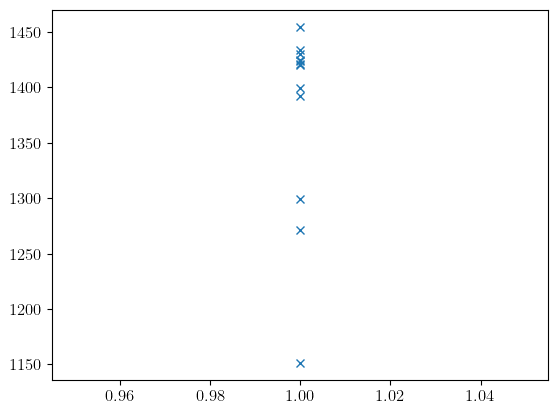

In [717]:
plt.plot(mf_p,np.array(cfm_p)*0.588,'x')

In [718]:
#plt.style.use('seaborn-whitegrid')
plt.style.use('default')
plt.rc('font',family = 'serif',size = 12)
plt.rc('text', usetex = True)

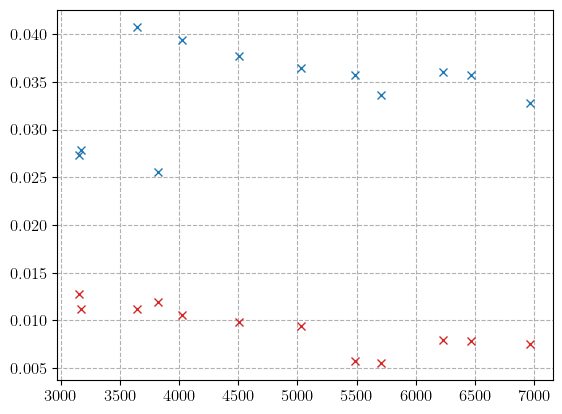

In [719]:
plt.plot(Reo_p,fo_p,'x',color = '#1f77b4')
plt.plot(Reo_p,jo_p,'x',color = '#d62728')

plt.grid(linestyle = 'dashed')

In [720]:
Data_Final = pd.DataFrame({'Xl':Xl_p,
                'Xt':Xt_p,
                'Nr':Nr_p,
                'Nl':Nl_p, 
                'L1':L1_p, 
                'Di':Di_p, 
                'pf':pf_p,
                'mf':mf_p, 
                'Nucleos':Nucleos_p, 
                'ECrC':Ecrc_p, 
                'ECrH':Ecrh_p, 
                'EffC':Efc_p, 
                'EffH':Efh_p, 
                'Cr':C_p, 
                'NTUC':NTUc_p, 
                'NTUH':NTUh_p, 
                'Wpc':Wpc_p, 
                'Wph':Wph_p, 
                'Wo':Wo_p, 
                'dPo':dPo_p,
                'vazao':cfm_p,
                'Reo':Reo_p,
                'fo':fo_p,
                'jo':jo_p,
                'etao':etao_p,
                'etaf':etaf_p,
                'mfin':mfin_p,
                'mhea':mhea_p,
                'mtub':mtub_p,
                'mwa':mwa_p,
                'dPc':dPc_p,
                'dPh':dPh_p,
             })

In [721]:
#Data_Final.to_excel("HEx_URM.xlsx") 

In [722]:
Data_Final

,Xl,Xt,Nr,Nl,L1,Di,pf,mf,Nucleos,ECrC,...,fo,jo,etao,etaf,mfin,mhea,mtub,mwa,dPc,dPh
0,0.033,0.031750,2.0,8.0,0.45,0.0148,0.004,1.0,4.0,0.068263,...,0.036081,0.007933,0.819713,0.234338,0.433855,0.013659,3.612586,2.864658,18657.573505,15814.839981
1,0.033,0.034925,6.0,6.0,0.55,0.0117,0.003,1.0,5.0,0.153755,...,0.027888,0.011234,0.762316,0.236695,4.566229,0.094160,9.709020,6.034064,82930.940767,70420.846480
2,0.033,0.034925,2.0,6.0,0.45,0.0148,0.003,1.0,5.0,0.063109,...,0.033596,0.005568,0.862973,0.227770,0.739483,0.017897,3.409793,2.703850,9481.165077,7990.426154
3,0.033,0.031750,2.0,6.0,0.55,0.0148,0.003,1.0,5.0,0.067801,...,0.035716,0.005696,0.871293,0.235727,0.662833,0.012805,4.035695,3.200170,10277.500124,8661.552154
4,0.033,0.034925,6.0,6.0,0.45,0.0117,0.004,1.0,5.0,0.138822,...,0.025504,0.011885,0.725751,0.237034,2.802004,0.094160,8.156759,5.069349,75628.110478,64219.644782
5,0.033,0.034925,8.0,6.0,0.55,0.0117,0.004,1.0,5.0,0.161470,...,0.027343,0.012726,0.746719,0.233405,4.566229,0.125547,12.945359,8.045419,110574.587690,93894.461973
6,0.033,0.034925,2.0,6.0,0.35,0.0148,0.004,1.0,5.0,0.057604,...,0.032774,0.007515,0.802796,0.241802,0.431365,0.017897,2.760897,2.189298,8684.830029,7319.300155
7,0.033,0.031750,2.0,6.0,0.45,0.0148,0.004,1.0,5.0,0.064211,...,0.035764,0.007792,0.817050,0.243392,0.406739,0.012805,3.386799,2.685617,9481.165077,7990.426154
8,0.033,0.034925,4.0,6.0,0.45,0.0148,0.004,1.0,5.0,0.102739,...,0.036496,0.009368,0.817385,0.258297,1.109224,0.035795,6.819585,5.407700,18962.330153,15980.852309
9,0.033,0.034925,4.0,6.0,0.55,0.0148,0.004,1.0,5.0,0.116068,...,0.037717,0.009843,0.825314,0.236139,1.355718,0.035795,8.117377,6.436805,20555.000248,17323.104309


IndexError: list index out of range

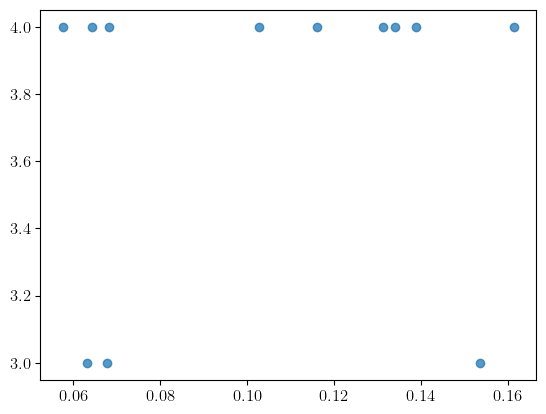

In [723]:
plt.plot(np.array(Ecrc_p[0:len(Ec_p_L[0])]),np.array(pf_p[0:len(Ec_p_L[0])])*1000,'o',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 4800 kg/h')
plt.plot(np.array(Ecrc_p[len(Ec_p_L[0]):len(Ec_p_L[0])+len(Ec_p_L[1])]),np.array(pf_p[len(Ec_p_L[0]):len(Ec_p_L[0])+len(Ec_p_L[1])])*1000,'x',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 6400 kg/h')
plt.plot(np.array(Ecrc_p[len(Ec_p_L[0])+len(Ec_p_L[1]):len(Ec_p_L[0])+len(Ec_p_L[1])+len(Ec_p_L[2])]),np.array(pf_p[len(Ec_p_L[0])+len(Ec_p_L[1]):len(Ec_p_L[0])+len(Ec_p_L[1])+len(Ec_p_L[2])])*1000,'P',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 8000 kg/h')
#plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]),'x')
#plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]),'s')

plt.xlabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.ylabel('$p_\mathrm{fin}$ [mm]')
plt.grid(linestyle = 'dashed')
#plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
#plt.legend(*sc.legend_elements("sizes", num=6), title = 'm$_\mathrm{HEx}$ [Kg]',bbox_to_anchor=[1.55, 0.45])
#sc.set_alpha(0.75)
plt.legend()

#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.ylim([0,0.16])

plt.savefig('HEx_pf.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')

In [ ]:
plt.plot(np.array(Ec_p_L[0:len(Ec_p_L[0])]),Ec_p_L[0],'o',alpha = 1, label = '$\dot{m}_\mathrm{HEx,l}$ = 2500 kg/h')
plt.plot(np.array(Ec_p_L[len(Ec_p_L[0]):len(Ec_p_L[0])+len(Ec_p_L[1])]),Ec_p_L[1],'x',alpha = 1, label = '$\dot{m}_\mathrm{HEx,l}$ = 5000 kg/h')
plt.plot(np.array(Ec_p_L[len(Ec_p_L[0])+len(Ec_p_L[1]):len(Ec_p_L[0])+len(Ec_p_L[1])+len(Ec_p_L[2])]),Ec_p_L[2],'P',alpha = 1, label = '$\dot{m}_\mathrm{HEx,l}$ = 7500 kg/h')
#plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]),'x')
#plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]),'s')

plt.ylabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.xlabel('$\dot{V}\llap{---}_\mathrm{a}$ [cfm]')
plt.grid(linestyle = 'dashed')
#plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
#plt.legend(*sc.legend_elements("sizes", num=6), title = 'm$_\mathrm{HEx}$ [Kg]',bbox_to_anchor=[1.55, 0.45])
#sc.set_alpha(0.5)
plt.legend(bbox_to_anchor=[0.55, 0.8])

#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
plt.ylim([0.03,0.23])

plt.savefig('HEx_Paretto.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')

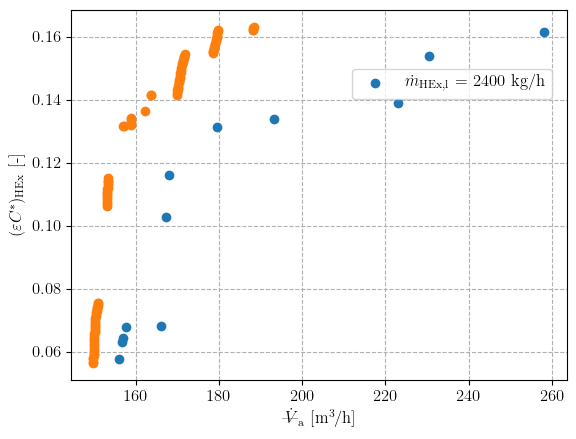

In [724]:
plt.plot(np.array(W_T_pc)[0],np.array(Ec_p_L)[0],'o',alpha = 1, label = '$\dot{m}_\mathrm{HEx,l}$ = 2400 kg/h')
plt.plot(res.F.T[1],-res.F.T[0],'o')
#plt.plot(np.array(W_T_pc)[1],np.array(Ec_p_L)[1],'x',alpha = 1, label = '$\dot{m}_\mathrm{HEx,l}$ = 3900 kg/h')
#plt.plot(np.array(W_T_pc)[2],np.array(Ec_p_L)[2],'P',alpha = 1, label = '$\dot{m}_\mathrm{HEx,l}$ = 5400 kg/h')
#plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]),'x')
#plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]),'s')

plt.ylabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.xlabel('$\dot{V}\llap{---}_\mathrm{a}$ [m$^3$/h]')
plt.grid(linestyle = 'dashed')
#plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
#plt.legend(*sc.legend_elements("sizes", num=6), title = 'm$_\mathrm{HEx}$ [Kg]',bbox_to_anchor=[1.55, 0.45])
#sc.set_alpha(0.5)
plt.legend(bbox_to_anchor=[0.55, 0.8])
#plt.legend()
#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.ylim([0.03,0.23])

#plt.savefig('HEx_Paretto.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')
plt.savefig('HEx_Paretto.jpg',format = 'jpg',dpi = 300,bbox_inches = 'tight')

In [ ]:
H_p = np.array(Xt_p)*np.array(Nl_p)*np.array(Nucleos_p)/2
L_p = np.array(Xl_p)*np.array(Nr_p)

In [ ]:
plt.plot(Ec_p_L[0],1000*np.array(L_p[0:len(Ec_p_L[0])]),'o',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 2400 kg/h')
plt.plot(Ec_p_L[1],1000*np.array(L_p[len(Ec_p_L[0]):len(Ec_p_L[0])+len(Ec_p_L[1])]),'x',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 3900 kg/h')
plt.plot(Ec_p_L[2],1000*np.array(L_p[len(Ec_p_L[0])+len(Ec_p_L[1]):len(Ec_p_L[0])+len(Ec_p_L[1])+len(Ec_p_L[2])]),'P',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 5400 kg/h')
#plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]),'x')
#plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]),'s')

plt.xlabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.ylabel('$L_\mathrm{HEx}$ [mm]')
plt.grid(linestyle = 'dashed')
#plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
#plt.legend(*sc.legend_elements("sizes", num=6), title = 'm$_\mathrm{HEx}$ [Kg]',bbox_to_anchor=[1.55, 0.45])
#plt.set_alpha(0.75)
#plt.legend(bbox_to_anchor=[0.28, 0.43])
plt.legend()
#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.ylim([0.29,0.57])

plt.savefig('HEx_L.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')

In [ ]:
plt.plot(Ec_p_L[0],1000*np.array(H_p[0:len(Ec_p_L[0])]),'o',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 2400 kg/h')
plt.plot(Ec_p_L[1],1000*np.array(H_p[len(Ec_p_L[0]):len(Ec_p_L[0])+len(Ec_p_L[1])]),'x',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 3900 kg/h')
plt.plot(Ec_p_L[2],1000*np.array(H_p[len(Ec_p_L[0])+len(Ec_p_L[1]):len(Ec_p_L[0])+len(Ec_p_L[1])+len(Ec_p_L[2])]),'P',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 5400 kg/h')
#plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]),'x')
#plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]),'s')

plt.xlabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.ylabel('$H_\mathrm{HEx}$ [mm]')
plt.grid(linestyle = 'dashed')
#plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
#plt.legend(*sc.legend_elements("sizes", num=6), title = 'm$_\mathrm{HEx}$ [Kg]',bbox_to_anchor=[1.55, 0.45])
#plt.set_alpha(0.75)
#plt.legend(bbox_to_anchor=[0.25, 0.17])
plt.legend()
#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
plt.xlim([0.06,0.27])

plt.savefig('HEx_H.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')

In [ ]:
plt.plot(Ec_p_L[0],1000*np.array(L1_p[0:len(Ec_p_L[0])]),'o',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 2400 kg/h')
plt.plot(Ec_p_L[1],1000*np.array(L1_p[len(Ec_p_L[0]):len(Ec_p_L[0])+len(Ec_p_L[1])]),'x',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 3900 kg/h')
plt.plot(Ec_p_L[2],1000*np.array(L1_p[len(Ec_p_L[0])+len(Ec_p_L[1]):len(Ec_p_L[0])+len(Ec_p_L[1])+len(Ec_p_L[2])]),'P',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 5400 kg/h')
#plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]),'x')
#plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]),'s')

plt.xlabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.ylabel('$W_\mathrm{HEx}$ [mm]')
plt.grid(linestyle = 'dashed')
#plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
#plt.legend(*sc.legend_elements("sizes", num=6), title = 'm$_\mathrm{HEx}$ [Kg]',bbox_to_anchor=[1.55, 0.45])
#plt.set_alpha(0.75)
#plt.legend(bbox_to_anchor=[0.25, 0.33])
plt.legend()
#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
plt.xlim([0.06,0.30])

plt.savefig('HEx_W.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')

In [ ]:
plt.plot(Ec_p_L[0],1000*np.array(Di_p[0:len(Ec_p_L[0])]),'o',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 2400 kg/h')
plt.plot(Ec_p_L[1],1000*np.array(Di_p[len(Ec_p_L[0]):len(Ec_p_L[0])+len(Ec_p_L[1])]),'x',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 3900 kg/h')
plt.plot(Ec_p_L[2],1000*np.array(Di_p[len(Ec_p_L[0])+len(Ec_p_L[1]):len(Ec_p_L[0])+len(Ec_p_L[1])+len(Ec_p_L[2])]),'P',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 5400 kg/h')
#plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]),'x')
#plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]),'s')

plt.xlabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.ylabel('$D_\mathrm{i}$ [mm]')
plt.grid(linestyle = 'dashed')
#plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
#plt.legend(*sc.legend_elements("sizes", num=6), title = 'm$_\mathrm{HEx}$ [Kg]',bbox_to_anchor=[1.55, 0.45])
#plt.set_alpha(0.75)
#plt.legend(bbox_to_anchor=[0.25, 0.33])
plt.legend()
#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.ylim([0.29,0.57])

plt.savefig('HEx_Di.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')

In [ ]:
plt.plot(Ec_p_L[0],1000*np.array(pf_p[0:len(Ec_p_L[0])]),'o',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 2400 kg/h')
plt.plot(Ec_p_L[1],1000*np.array(pf_p[len(Ec_p_L[0]):len(Ec_p_L[0])+len(Ec_p_L[1])]),'x',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 3900 kg/h')
plt.plot(Ec_p_L[2],1000*np.array(pf_p[len(Ec_p_L[0])+len(Ec_p_L[1]):len(Ec_p_L[0])+len(Ec_p_L[1])+len(Ec_p_L[2])]),'P',alpha = 0.75, label = '$\dot{m}_\mathrm{HEx,l}$ = 5400 kg/h')
#plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]),'x')
#plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]),'s')

plt.xlabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.ylabel('$p_\mathrm{fin}$ [mm]')
plt.grid(linestyle = 'dashed')
#plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
#plt.legend(*sc.legend_elements("sizes", num=6), title = 'm$_\mathrm{HEx}$ [Kg]',bbox_to_anchor=[1.55, 0.45])
#plt.set_alpha(0.75)
plt.legend(bbox_to_anchor=[0.5, 0.4])
#plt.legend()
#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.ylim([0.29,0.57])

plt.savefig('HEx_pf.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')

In [ ]:

plt.plot(Ec_p_L[0],(Xl_p[0:len(Ec_p_L[0])]-min(Xl_p[0:len(Ec_p_L[0])]))/(max(Xl_p[0:len(Ec_p_L[0])])-min(Xl_p[0:len(Ec_p_L[0])])),'o')
plt.plot(Ec_p_L[0],(Xt_p[0:len(Ec_p_L[0])]-min(Xt_p[0:len(Ec_p_L[0])]))/(max(Xt_p[0:len(Ec_p_L[0])])-min(Xt_p[0:len(Ec_p_L[0])])),'o')
plt.plot(Ec_p_L[0],(L1_p[0:len(Ec_p_L[0])]-min(L1_p[0:len(Ec_p_L[0])]))/(max(L1_p[0:len(Ec_p_L[0])])-min(L1_p[0:len(Ec_p_L[0])])),'o')
plt.plot(Ec_p_L[0],(Nucleos_p[0:len(Ec_p_L[0])]-min(Nucleos_p[0:len(Ec_p_L[0])]))/(max(Nucleos_p[0:len(Ec_p_L[0])])-min(Nucleos_p[0:len(Ec_p_L[0])])),'o')
plt.plot(Ec_p_L[0],(Nr_p[0:len(Ec_p_L[0])]-min(Nr_p[0:len(Ec_p_L[0])]))/(max(Nr_p[0:len(Ec_p_L[0])])-min(Nr_p[0:len(Ec_p_L[0])])),'o')
plt.plot(Ec_p_L[0],(Nl_p[0:len(Ec_p_L[0])]-min(Nl_p[0:len(Ec_p_L[0])]))/(max(Nl_p[0:len(Ec_p_L[0])])-min(Nl_p[0:len(Ec_p_L[0])])),'o')
plt.plot(Ec_p_L[0],(pf_p[0:len(Ec_p_L[0])]-min(pf_p[0:len(Ec_p_L[0])]))/(max(pf_p[0:len(Ec_p_L[0])])-min(pf_p[0:len(Ec_p_L[0])])),'o')


Data_Final.to_excel("Results.xlsx") 

In [85]:
EcrC = Data_Final['ECrC']
#WTT = Data_Final['Wo'] + Data_Final['Wpc']
WTT =  Data_Final['Wpc']

In [86]:
DataF = Data_Final.groupby('mf')
Ecr_mf = DataF.get_group(m_f[0])['ECrC']
WTT_mf = DataF.get_group(m_f[0])['Wo'] + DataF.get_group(m_f[0])['Wpc']

In [87]:
len(WTT_mf)

14

In [88]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)
cmap = ('viridis')

Text(0.5, 0, 'Power [W]')

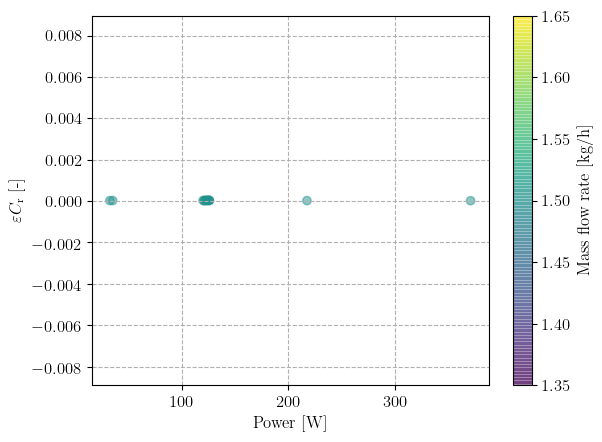

In [89]:
plt.grid(linestyle = 'dashed')
plt.scatter(WTT,EcrC, alpha = 0.5, c = Data_Final['mf'],cmap = 'viridis')

#plt.scatter(WTT_mf,Ecr_mf)
#lt.plot(WTT,Ecr,'o')
plt.colorbar(label = 'Mass flow rate [kg/h]')
plt.ylabel(r'$\varepsilon C_\mathrm{r}$ [-]')
plt.xlabel('Power [W]')


In [350]:
Wt_1 = WTT
Ec_1 = EcrC

In [ ]:
plt.semilogx(Wt_1,Ec_1,'o',label = 'N$_\mathrm{Circ}$ = 1')
plt.semilogx(Wt_2,Ec_2,'x',label = 'N$_\mathrm{Circ}$ = 2')
plt.semilogx(Wt_3,Ec_3,'s',label = 'N$_\mathrm{Circ}$ = 3')
plt.semilogx(Wt_4,Ec_4,'^',label = 'N$_\mathrm{Circ}$ = 4')
plt.semilogx(Wt_6,Ec_6,'v',label = 'N$_\mathrm{Circ}$ = 6')
#plt.semilogx(Wt_12,Ec_12,'.',label = 'N$_\mathrm{Circ}$ = 12')
plt.legend()
plt.grid(linestyle = 'dashed')
plt.xlim(0,10000)
plt.ylabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.xlabel('$\dot{W}_\mathrm{HEx,pump}$ [W]')
plt.savefig('N_Circ.pdf',format = 'pdf', dpi=1000,bbox_inches='tight')

In [513]:
s1 = 'L1'
size = (5*(np.array(df_mf.get_group(m_f[0])[s1]) - min(np.array(df_mf.get_group(m_f[0])[s1])))/(max(np.array(df_mf.get_group(m_f[0])[s1])) - min(np.array(df_mf.get_group(m_f[0])[s1]))))**2



c1 = 'mf'
#col = np.array(df_mf.get_group(m_f[0])[c1])
size =  m_tot[0][0]
col = np.array(df_mf.get_group(m_f[0])[s1])

In [346]:
DataF = Data_Final.groupby('mf')
Ecr = DataF.get_group(m_f[0])['ECrC']
WTT = DataF.get_group(m_f[0])['Wo'] + DataF.get_group(m_f[0])['Wpc']

In [347]:
Data_Final['W_total'] = Data_Final['Wo'] + Data_Final['Wpc']

In [348]:
Data_Final[Data_Final['W_total']<350]

,Xl,Xt,Nr,Nl,L1,Di,pf,mf,Nucleos,ECrC,...,jo,etao,etaf,mfin,mhea,mtub,mwa,dPc,dPh,W_total
56,0.028875,0.036512,8.0,6.0,0.43,0.0148,0.0043,1.5,5.0,0.077083,...,0.010470,0.885284,0.247107,1.479043,0.052494,13.058928,10.386447,75745.939983,64503.083600,272.708871
57,0.030250,0.031750,6.0,6.0,0.49,0.0148,0.0050,1.5,5.0,0.070303,...,0.010837,0.866482,0.247102,0.740908,0.025686,10.879743,8.653228,59721.267134,50856.928932,248.601811
59,0.033000,0.038100,8.0,4.0,0.39,0.0117,0.0030,1.5,6.0,0.081381,...,0.010813,0.739862,0.247120,4.000533,0.116732,7.768344,4.842480,93692.594770,80030.932244,299.704493
60,0.030250,0.031750,6.0,4.0,0.43,0.0117,0.0036,1.5,6.0,0.070614,...,0.010413,0.781305,0.247107,1.689168,0.052923,6.195196,3.861841,73150.522177,62484.174960,268.804306
61,0.033000,0.031750,8.0,4.0,0.49,0.0117,0.0030,1.5,7.0,0.085603,...,0.011218,0.765442,0.249422,4.261008,0.098167,10.854865,6.766496,78793.543965,67030.293858,276.328721
62,0.033000,0.031750,8.0,4.0,0.53,0.0117,0.0030,1.5,7.0,0.090370,...,0.011349,0.767737,0.257667,4.608846,0.098167,11.627546,7.248155,81723.761294,69523.053020,277.143080
63,0.033000,0.031750,8.0,4.0,0.45,0.0117,0.0030,1.5,8.0,0.088332,...,0.011295,0.766976,0.254983,4.472195,0.112191,11.522496,7.182671,60047.173992,50901.487287,245.751571
64,0.033000,0.031750,8.0,4.0,0.47,0.0117,0.0030,1.5,8.0,0.090970,...,0.011372,0.768305,0.258728,4.670959,0.112191,11.964028,7.457905,61206.833590,51884.521031,245.761957
65,0.033000,0.031750,8.0,4.0,0.49,0.0117,0.0030,1.5,8.0,0.093493,...,0.011450,0.769663,0.261257,4.869724,0.112191,12.405560,7.733138,62366.493188,52867.554776,246.129395
66,0.033000,0.031750,8.0,4.0,0.53,0.0117,0.0030,1.5,8.0,0.098210,...,0.011613,0.772442,0.263287,5.267252,0.112191,13.288624,8.283606,64685.812385,54833.622265,247.643501


In [349]:
DataF.get_group(m_f[0])

,Xl,Xt,Nr,Nl,L1,Di,pf,mf,Nucleos,ECrC,...,jo,etao,etaf,mfin,mhea,mtub,mwa,dPc,dPh,W_total
0,0.03300,0.038100,8.0,8.0,0.39,0.0117,0.0030,1.5,3.0,0.082501,...,0.010813,0.739862,0.247120,4.000533,0.116732,7.768344,4.842480,640293.878577,557139.783733,1122.073526
1,0.03025,0.038100,8.0,6.0,0.53,0.0117,0.0030,1.5,3.0,0.081077,...,0.010292,0.791895,0.247109,3.520148,0.075328,7.530537,4.694241,549132.726738,477817.606652,984.924892
2,0.03300,0.033337,8.0,8.0,0.53,0.0117,0.0030,1.5,3.0,0.087410,...,0.011148,0.759654,0.252690,4.321985,0.092290,9.995458,6.230775,732176.968984,637090.142202,1257.973814
3,0.03300,0.033337,8.0,8.0,0.55,0.0117,0.0030,1.5,3.0,0.089657,...,0.011210,0.760773,0.256433,4.485078,0.092290,10.326607,6.437200,745303.124756,648511.621984,1276.079266
4,0.03025,0.031750,6.0,8.0,0.43,0.0117,0.0036,1.5,3.0,0.071881,...,0.010413,0.781305,0.247107,1.689168,0.052923,6.195196,3.861841,499909.642592,434987.057472,910.869181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.03300,0.031750,8.0,4.0,0.49,0.0117,0.0030,1.5,8.0,0.093493,...,0.011450,0.769663,0.261257,4.869724,0.112191,12.405560,7.733138,62366.493188,52867.554776,246.129395
66,0.03300,0.031750,8.0,4.0,0.53,0.0117,0.0030,1.5,8.0,0.098210,...,0.011613,0.772442,0.263287,5.267252,0.112191,13.288624,8.283606,64685.812385,54833.622265,247.643501
67,0.03300,0.033337,8.0,4.0,0.53,0.0117,0.0030,1.5,8.0,0.103230,...,0.011737,0.770334,0.260926,5.762646,0.123054,13.327277,8.307700,64685.812385,54833.622265,245.990949
68,0.03300,0.031750,8.0,4.0,0.55,0.0117,0.0030,1.5,8.0,0.100414,...,0.011696,0.773853,0.263060,5.466016,0.112191,13.730156,8.558839,65845.471983,55816.656009,248.686732


In [350]:
DataFi = Data_Final
DataF = DataFi.groupby('mf')

In [351]:
#DataF = Data_Final.groupby('mf')
col  = np.array(DataF.get_group(m_f[0])['L1'])
size = np.array(DataF.get_group(m_f[0])['mfin']+DataF.get_group(m_f[0])['mhea']+DataF.get_group(m_f[0])['mwa']+DataF.get_group(m_f[0])['mtub'])
Ecr_mf = DataF.get_group(m_f[0])['ECrC']
WTT_mf = DataF.get_group(m_f[0])['Wo'] + DataF.get_group(m_f[0])['Wpc']

m_tot_1 = mfin_1+mhea_1+mtub_1+mwa_1


In [352]:
DFF = pd.DataFrame(np.array([cfm_1[2][0],ECr[2][0],W_Tc[2][0],m_tot[2][0]]).T,
                              columns = ['cfm','ECr','W','m'])

IndexError: list index out of range

In [353]:
DFF['W']

0        325.855073
1        323.279374
2        321.829808
3        321.041099
4        325.405014
            ...    
64530    187.326625
64531    190.746996
64532    186.754783
64533    189.791975
64534    186.297370
Name: W, Length: 45113, dtype: float64

In [354]:
DFF= DFF[DFF['W']<350]


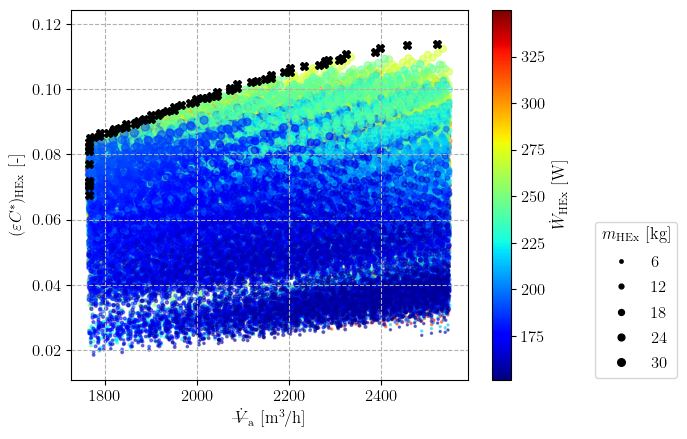

In [356]:
i = 0
sc = plt.scatter(DFF['cfm'],DFF['ECr'],marker = 'o',cmap = 'jet', c = DFF['W'],s = DFF['m'],rasterized=True)#, alpha = 1, s = size, c = col,cmap = 'viridis')
#sc = plt.scatter(cfm_1[i][0]*0.588,ECr[i][0],marker = 'o',cmap = 'jet', c= Xl_1[i][0])#, alpha = 1, s = size, c = col,cmap = 'viridis')

Ecr = DataF.get_group(m_f[i])['ECrC']
WTT = DataF.get_group(m_f[i])['Wo'] + DataF.get_group(m_f[i])['Wpc']

plt.plot(np.array(cfm_p_L[i]),Ec_p_L[i],'X',color = 'black', label = 'Pareto Front')
#plt.set_legend()
#plt.plot(np.array(W_p_L[0]),np.array(Ec_p_L[0]),'o',alpha = 0.8)

plt.ylabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.xlabel('$\dot{V}\llap{---}_\mathrm{a}$ [m$^3$/h]')
plt.grid(linestyle = 'dashed')
plt.colorbar(label = '$\dot{W}_\mathrm{HEx}$ [W]')
plt.legend(*sc.legend_elements("sizes", num=6), title = '$m_\mathrm{HEx}$ [kg]',bbox_to_anchor=[1.55, 0.45])
sc.set_alpha(0.5)
#plt.legend()

#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.ylim([0,0.16])

#plt.savefig('HEx_5400_cfm.pdf',format = 'pdf',bbox_inches='tight')
plt.savefig('HEx_5400_cfm.jpg',format = 'jpg',dpi = 300,bbox_inches = 'tight')

PermissionError: [Errno 13] Permission denied: 'HEx_2400.pdf'

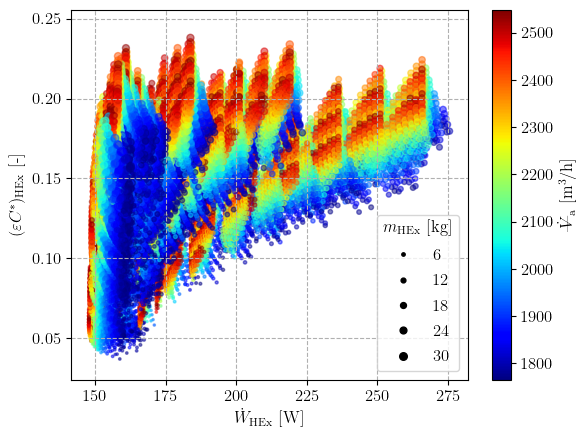

In [433]:
i = 0

sc = plt.scatter(W_Tc[i][0],ECr[i][0],marker = 'o',cmap = 'jet', c = cfm_1[i][0],s = m_tot[i][0],rasterized=True)#, alpha = 1, s = size, c = col,cmap = 'viridis')

Ecr = DataF.get_group(m_f[i])['ECrC']
WTT = DataF.get_group(m_f[i])['Wo'] + DataF.get_group(m_f[i])['Wpc']

#plt.plot(WTT,Ecr,'x',color = 'black', mfc='none', label = 'Pareto Front',alpha = 0.65)
#plt.set_legend()
#plt.plot(np.array(W_p_L[0]),np.array(Ec_p_L[0]),'o',alpha = 0.8)

plt.ylabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.xlabel('$\dot{W}_\mathrm{HEx}$ [W]')
plt.grid(linestyle = 'dashed')
plt.colorbar(label = '$\dot{V}\llap{---}_\mathrm{a}$ [m$^3$/h]')
plt.legend(*sc.legend_elements("sizes", num=6), title = '$m_\mathrm{HEx}$ [kg]')
sc.set_alpha(0.5)
#plt.legend()

#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.xlim([146,170.5])
plt.savefig('HEx_2400.pdf',format = 'pdf',bbox_inches='tight')

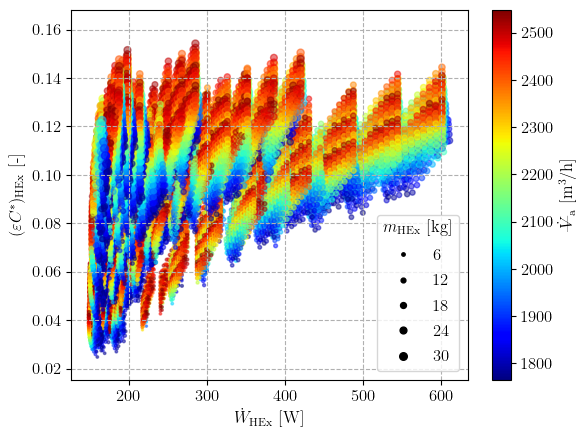

In [364]:
i = 1

sc = plt.scatter(W_Tc[i][0],ECr[i][0],marker = 'o',cmap = 'jet', c = cfm_1[i][0],s = m_tot[i][0],rasterized=True)#, alpha = 1, s = size, c = col,cmap = 'viridis')

Ecr = DataF.get_group(m_f[i])['ECrC']
WTT = DataF.get_group(m_f[i])['Wo'] + DataF.get_group(m_f[i])['Wpc']

#plt.plot(WTT,Ecr,'x',color = 'black', mfc='none', label = 'Pareto Front',alpha = 0.65)
#plt.set_legend()
#plt.plot(np.array(W_p_L[0]),np.array(Ec_p_L[0]),'o',alpha = 0.8)

plt.ylabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.xlabel('$\dot{W}_\mathrm{HEx}$ [W]')
plt.grid(linestyle = 'dashed')
plt.colorbar(label = '$\dot{V}\llap{---}_\mathrm{a}$ [m$^3$/h]')
plt.legend(*sc.legend_elements("sizes", num=6), title = '$m_\mathrm{HEx}$ [kg]')
sc.set_alpha(0.5)
#plt.legend()

#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.xlim([146,170.5])
plt.savefig('HEx_3900.pdf',format = 'pdf',bbox_inches='tight')

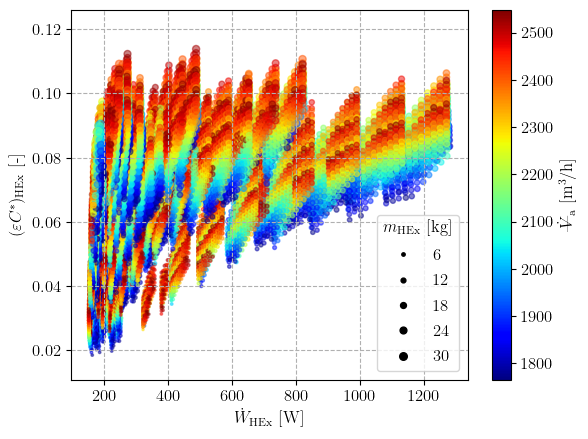

In [554]:
i = 0

sc = plt.scatter(W_Tc[i][0],ECr[i][0],marker = 'o',cmap = 'jet', c = cfm_1[i][0],s = m_tot[i][0],rasterized=True)#, alpha = 1, s = size, c = col,cmap = 'viridis')

Ecr = DataF.get_group(m_f[i])['ECrC']
WTT = DataF.get_group(m_f[i])['Wo'] + DataF.get_group(m_f[i])['Wpc']

#plt.plot(WTT,Ecr,'x',color = 'black', mfc='none', label = 'Pareto Front',alpha = 0.65)
#plt.set_legend()
#plt.plot(np.array(W_p_L[0]),np.array(Ec_p_L[0]),'o',alpha = 0.8)

plt.ylabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.xlabel('$\dot{W}_\mathrm{HEx}$ [W]')
plt.grid(linestyle = 'dashed')
plt.colorbar(label = '$\dot{V}\llap{---}_\mathrm{a}$ [m$^3$/h]')
plt.legend(*sc.legend_elements("sizes", num=6), title = '$m_\mathrm{HEx}$ [kg]')
sc.set_alpha(0.5)
#plt.legend()
#plt.xlim([0,350])
#plt.savefig(HEx, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)      
#plt.xlim([146,170.5])
plt.savefig('HEx_5400.pdf',format = 'pdf',bbox_inches='tight')

In [ ]:
#plt.scatter(m_tot[0][0],ECr[0][0], c = np.array(df_mf.get_group(m_f[0])['m_w']/m_tot[0][0]))
plt.scatter(m_tot[0][0],ECr[0][0], c = col)
plt.colorbar(label = 'Internal Pumping Power [W]')
plt.grid()

In [ ]:
df_final = pd.DataFrame(columns = ['Xl','Xt','N_r','N_l','L1','Di','pf','xf','sigmaf','sigmah','p_d','m_f','Nucleos','ECr_c','ECr_h','Eff_c','Eff_h','C_r','NTU_c','NTU_h','W_p_c','W_p_h','W_o','dP_o','vazao*3600','Re_o','f_o','j_o','eta_o','eta_fan','m_fin','m_hea','m_tub','m_w','dP_c','dP_h'])


In [ ]:
A = [[] for i in range(len(Cont[0]))]

In [ ]:
np.array(df)[Cont[0][0]]

In [ ]:
A[1].append(np.array(df)[Cont[0][1]])

In [ ]:
A = np.array(df)[Cont[0][1]]

In [ ]:
A

In [ ]:
A.append(np.array(df)[Cont[0][0]])

In [ ]:
df_final.append(np.array(df)[Cont[0][0]])